# **Movie Recommender Systems**

As a movie lover I believe that finding the perfect film to watch can often be a tough task. There are countless options available and we, movie enthusiasts, often wonder which film will provide the best experience. That is where recommender systems step in.
In this notebook I will try to scrape some movie data from TMDB and gain some insights by exploring and visualizing. Next step will be to use the uncovered patterns, trends and insights to make a few types of recommender systems. For the last type I will try to merge 3 datasets in order to use the movie data scraped from TMDB with the user ratings of a dataset found on kaggle.

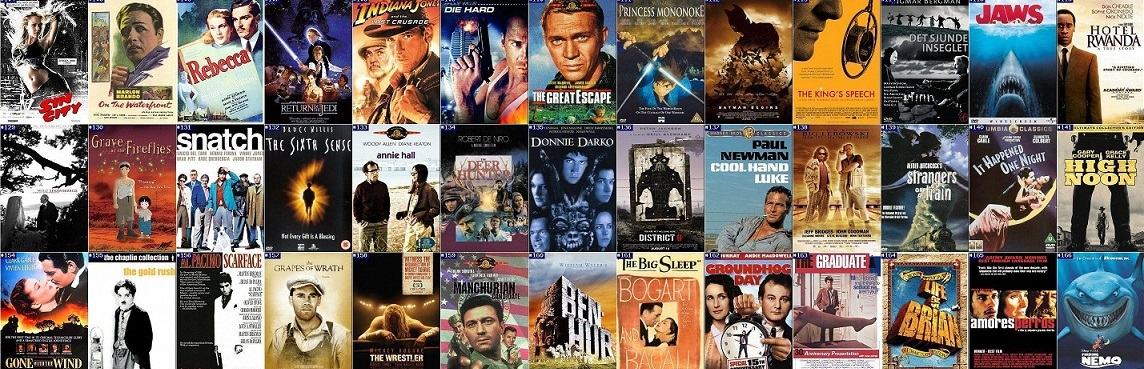

# Importing Libraries and Scraping the Data

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import requests
from collections import Counter
from datetime import datetime
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import wordcloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [3]:
# Scrape movie data from themoviedb.org

API_KEY = '4ee72f1e08d6207fb15fe402b7fca928'

page = 1
total_pages = 500

csv_file = open('movies.csv', 'w', newline='', encoding='utf-8')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['id', 'title', 'genre_ids', 'popularity', 
                     'release_date', 'original_language', 'vote_average', 'vote_count', 'overview'])

while page <= total_pages:
    url = f'https://api.themoviedb.org/3/discover/movie?api_key={API_KEY}&page={page}'
    response = requests.get(url)
    data = response.json()

    for movie in data['results']:
        id = movie['id']
        title = movie['title']
        genre_ids = movie['genre_ids']
        popularity = movie['popularity']
        release_date = movie.get('release_date', 'N/A')
        original_language = movie['original_language']
        vote_average = movie['vote_average']
        vote_count = movie['vote_count']
        overview = movie.get('overview', 'N/A')
        

        csv_writer.writerow([id, title, genre_ids, popularity, release_date, 
                             original_language, vote_average, vote_count, overview])

    page += 1

csv_file.close()

In [4]:
movies = pd.read_csv('/kaggle/working/movies.csv')

# Understanding the data

In [5]:
movies.shape

(10000, 9)

In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10000 non-null  int64  
 1   title              10000 non-null  object 
 2   genre_ids          10000 non-null  object 
 3   popularity         10000 non-null  float64
 4   release_date       9982 non-null   object 
 5   original_language  10000 non-null  object 
 6   vote_average       10000 non-null  float64
 7   vote_count         10000 non-null  int64  
 8   overview           9904 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 703.2+ KB


In [7]:
movies.head()

,id,title,genre_ids,popularity,release_date,original_language,vote_average,vote_count,overview
0,569094,Spider-Man: Across the Spider-Verse,"[16, 28, 12, 878]",2904.593,2023-05-31,en,8.5,3420,"After reuniting with Gwen Stacy, Brooklyn’s fu..."
1,976573,Elemental,"[16, 35, 10751, 14, 10749]",2396.197,2023-06-14,en,7.7,943,"In a city where fire, water, land and air resi..."
2,667538,Transformers: Rise of the Beasts,"[28, 12, 878]",1924.017,2023-06-06,en,7.5,2770,When a new threat capable of destroying the en...
3,346698,Barbie,"[35, 12, 14]",1893.500,2023-07-19,en,7.4,3058,Barbie and Ken are having the time of their li...
4,884605,No Hard Feelings,"[35, 10749]",1860.113,2023-06-15,en,7.1,598,"On the brink of losing her childhood home, Mad..."


In [8]:
movies.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10000.0,299296.26380,338978.678922,5.000,11480.750,118784.500,529887.00000,1162884.000
popularity,10000.0,31.71857,76.328377,13.184,15.512,19.552,28.95225,2904.593
vote_average,10000.0,6.33732,1.434382,0.000,5.900,6.600,7.10000,10.000
vote_count,10000.0,1576.27630,2920.496455,0.000,151.000,523.000,1602.00000,34248.000


# Data Preprocessing

In [9]:
movies[movies.duplicated()]

,id,title,genre_ids,popularity,release_date,original_language,vote_average,vote_count,overview


In [10]:
movies.drop_duplicates(inplace=True)

In [11]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10000 non-null  int64  
 1   title              10000 non-null  object 
 2   genre_ids          10000 non-null  object 
 3   popularity         10000 non-null  float64
 4   release_date       9982 non-null   object 
 5   original_language  10000 non-null  object 
 6   vote_average       10000 non-null  float64
 7   vote_count         10000 non-null  int64  
 8   overview           9904 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 781.2+ KB


In [12]:
movies.release_date.fillna('NaT', inplace = True)
movies.overview.fillna('None', inplace = True)

In [13]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10000 non-null  int64  
 1   title              10000 non-null  object 
 2   genre_ids          10000 non-null  object 
 3   popularity         10000 non-null  float64
 4   release_date       10000 non-null  object 
 5   original_language  10000 non-null  object 
 6   vote_average       10000 non-null  float64
 7   vote_count         10000 non-null  int64  
 8   overview           10000 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 781.2+ KB


In [14]:
movies.shape

(10000, 9)

In [15]:
movies['release_date'] = pd.to_datetime(movies['release_date'])

In [16]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 10000 non-null  int64         
 1   title              10000 non-null  object        
 2   genre_ids          10000 non-null  object        
 3   popularity         10000 non-null  float64       
 4   release_date       9982 non-null   datetime64[ns]
 5   original_language  10000 non-null  object        
 6   vote_average       10000 non-null  float64       
 7   vote_count         10000 non-null  int64         
 8   overview           10000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 781.2+ KB


# Exploratory Data Analysis

/tmp/ipykernel_32/1515071205.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(release_date_counts.index, release_date_counts.values, linestyle='solid', marker=None)


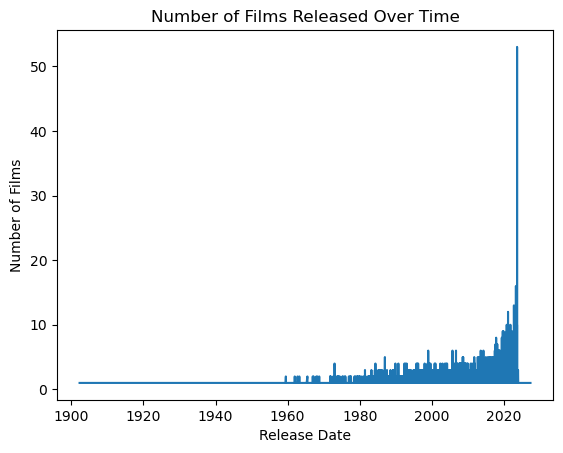

In [17]:
# Number of Films Released Over Time

release_date_counts = movies.release_date.value_counts().sort_index()
plt.plot_date(release_date_counts.index, release_date_counts.values, linestyle='solid', marker=None)
plt.xlabel('Release Date')
plt.ylabel('Number of Films')
plt.title('Number of Films Released Over Time')
plt.show()

In [18]:
# To be released

today = datetime.today()

to_be_released = movies[movies.release_date >= today]
to_be_released.head()

,id,title,genre_ids,popularity,release_date,original_language,vote_average,vote_count,overview
84,954388,Quicksand,"[53, 27]",204.877,2023-08-31,en,0.0,0,A married couple on the brink of divorce becom...
176,820525,After Everything,"[10749, 18]",125.977,2023-09-13,en,0.0,0,Besieged by writer’s block and the crushing br...
203,968051,The Nun II,"[27, 9648, 53]",115.283,2023-09-05,en,0.0,0,Four years after the events at the Abbey of St...
214,926393,The Equalizer 3,"[28, 53, 80]",113.196,2023-08-30,en,0.0,0,Robert McCall finds himself at home in Souther...
398,695721,The Hunger Games: The Ballad of Songbirds & Sn...,"[28, 12, 878]",79.212,2023-11-09,en,0.0,0,Years before he becomes the tyrannical preside...


In [19]:
# 10 most popular films at the moment

top_10 = movies.sort_values('popularity', ascending = False)[['release_date', 'title', 'popularity']].head(10)
top_10

,release_date,title,popularity
0,2023-05-31,Spider-Man: Across the Spider-Verse,2904.593
1,2023-06-14,Elemental,2396.197
2,2023-06-06,Transformers: Rise of the Beasts,1924.017
3,2023-07-19,Barbie,1893.500
4,2023-06-15,No Hard Feelings,1860.113
5,2023-08-02,Meg 2: The Trench,1659.416
6,2023-06-13,The Flash,1650.607
7,2023-07-14,The Flood,1479.025
8,2023-07-05,Insidious: The Red Door,1382.748
9,2023-08-02,Soulcatcher,1192.508


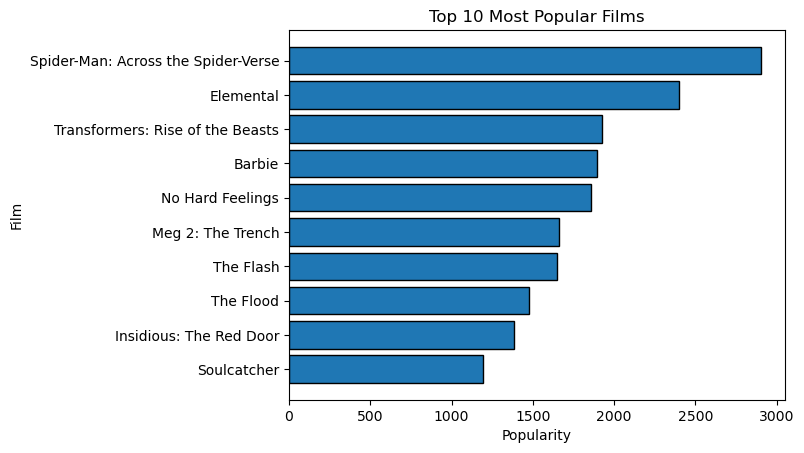

In [20]:
# Visualize Top 10 Most Popular Films at the Moment

plt.barh(top_10['title'], top_10['popularity'], edgecolor='black')
plt.title('Top 10 Most Popular Films')
plt.xlabel('Popularity')
plt.ylabel('Film')
plt.gca().invert_yaxis()
plt.show()

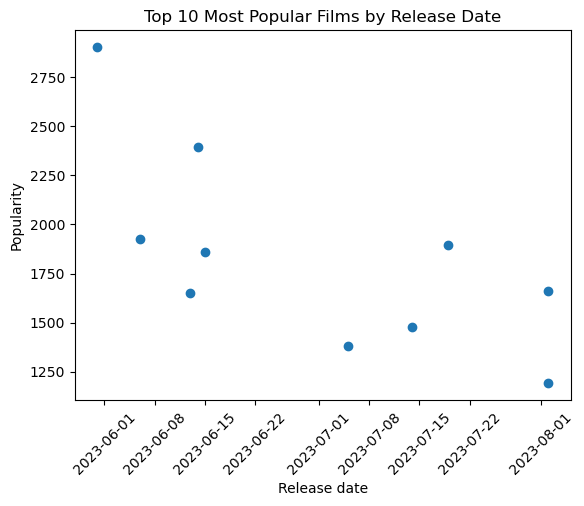

In [21]:
# Top 10 Most Popular Films by Release Date

plt.scatter(top_10['release_date'], top_10['popularity'])
plt.xlabel('Release date')
plt.ylabel('Popularity')
plt.title('Top 10 Most Popular Films by Release Date')
plt.xticks(rotation=45)
plt.show()

In [22]:
# 10 Least Popular Films at the Moment
# Probably not interesting enough to be visualized

movies.sort_values('popularity', ascending = True)[['release_date', 'title', 'popularity']].head(10)

,release_date,title,popularity
9999,2016-07-14,Toni Erdmann,13.184
9998,NaT,Untitled Luke Hobbs Project,13.184
9997,2016-12-08,The Dreamseller,13.185
9994,2006-09-13,Seraphim Falls,13.186
9996,2005-09-21,Prime,13.186
9995,1969-09-15,Battle of Britain,13.186
9993,2001-01-26,The Wedding Planner,13.188
9991,2013-09-13,Deseo,13.190
9992,1997-12-25,Wag the Dog,13.190
9989,2018-10-13,Up to You,13.192


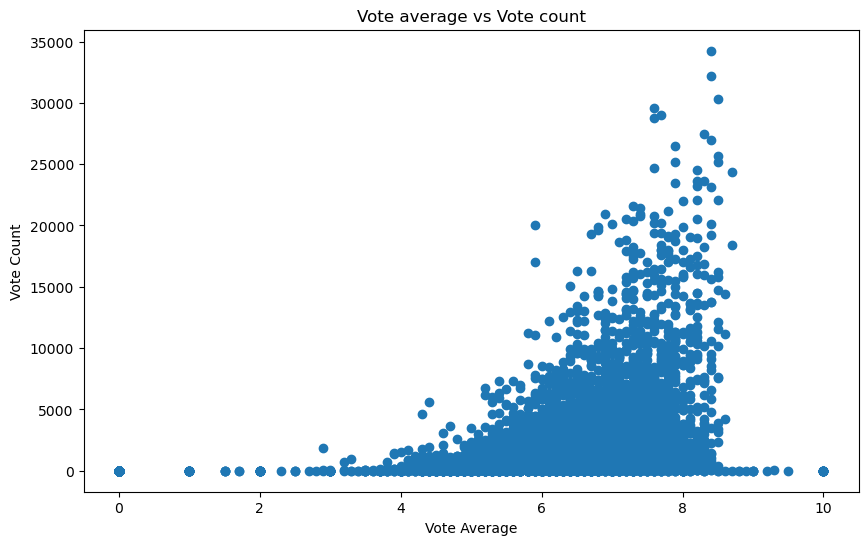

In [23]:
# Films with higher vote averages tend to have higher vote counts

plt.figure(figsize=(10, 6))
plt.scatter(movies['vote_average'], movies['vote_count'])
plt.title('Vote average vs Vote count')
plt.xlabel('Vote Average')
plt.ylabel('Vote Count')
plt.show()

In [24]:
movies['original_language'].value_counts().head()

en    7234
ja     684
ko     424
fr     329
es     292
Name: original_language, dtype: int64

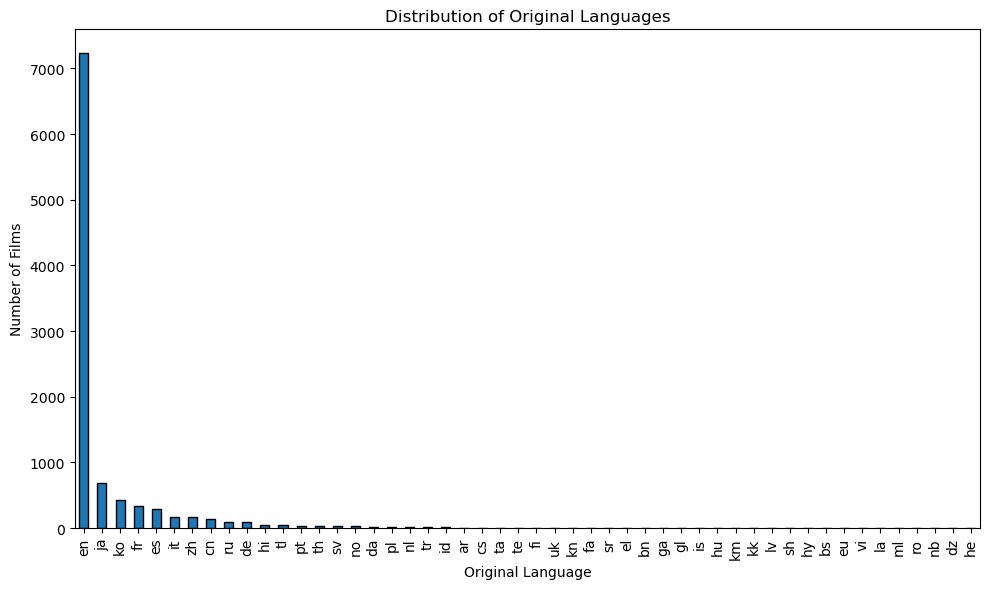

In [25]:
# Distribution of original languages 

plt.figure(figsize=(10, 6))
movies['original_language'].value_counts().plot(kind = 'bar', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xlabel('Original Language')
plt.ylabel('Number of Films')
plt.title('Distribution of Original Languages')
plt.tight_layout()
plt.show()

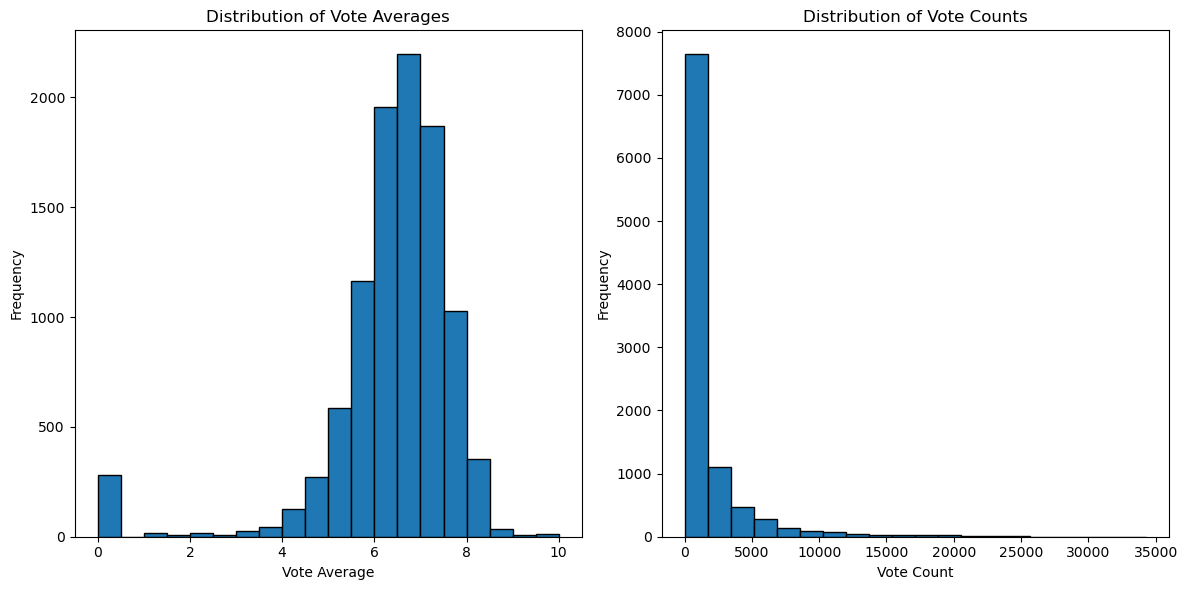

Vote Average Mean: 6.34
Vote Average Median: 6.60
Vote Average Standard Deviation: 1.43
Vote Count Mean: 1576.28
Vote Count Median: 523.00
Vote Count Standard Deviation: 2920.50


In [26]:
# Analyze the distribution of vote averages and counts

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].hist(movies['vote_average'], bins=20, edgecolor='black')
axes[0].set_title('Distribution of Vote Averages')
axes[0].set_xlabel('Vote Average')
axes[0].set_ylabel('Frequency')

axes[1].hist(movies['vote_count'], bins=20, edgecolor='black')
axes[1].set_title('Distribution of Vote Counts')
axes[1].set_xlabel('Vote Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate summary statistics for vote averages and vote counts

vote_avg_mean = movies['vote_average'].mean()
vote_avg_median = movies['vote_average'].median()
vote_avg_std = movies['vote_average'].std()

vote_count_mean = movies['vote_count'].mean()
vote_count_median = movies['vote_count'].median()
vote_count_std = movies['vote_count'].std()

print(f"Vote Average Mean: {vote_avg_mean:.2f}")
print(f"Vote Average Median: {vote_avg_median:.2f}")
print(f"Vote Average Standard Deviation: {vote_avg_std:.2f}")

print(f"Vote Count Mean: {vote_count_mean:.2f}")
print(f"Vote Count Median: {vote_count_median:.2f}")
print(f"Vote Count Standard Deviation: {vote_count_std:.2f}")

# Natural language processing

In [27]:
# 20 most common characters

characters = Counter("\n".join(movies.overview.tolist())).most_common(20)
characters

[(' ', 464453),
 ('e', 270653),
 ('t', 184194),
 ('a', 181273),
 ('i', 161291),
 ('n', 161039),
 ('o', 159941),
 ('s', 149302),
 ('r', 145938),
 ('h', 118234),
 ('l', 90399),
 ('d', 78488),
 ('c', 59864),
 ('u', 58338),
 ('m', 53104),
 ('f', 50366),
 ('g', 49218),
 ('p', 38334),
 ('y', 37957),
 ('w', 36364)]

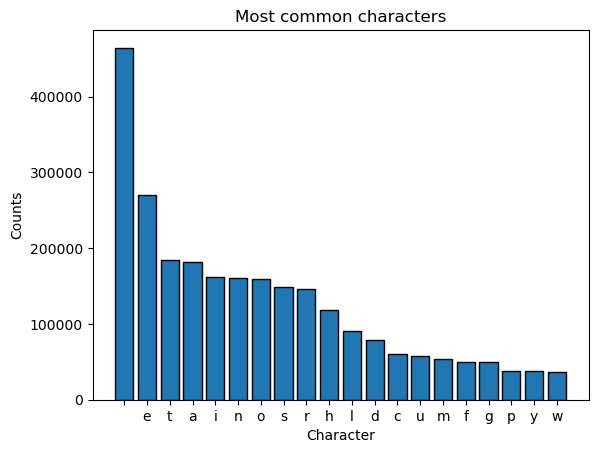

In [28]:
# The distribution is similar to the most common one in English language (Etaoin shrdlu)

plt.bar([ch[0] for ch in characters], [ch[1] for ch in characters], edgecolor='black')
plt.xlabel('Character')
plt.ylabel('Counts')
plt.title('Most common characters')
plt.show()

In [29]:
# Join the overviews and work on one big text

large_text = ' '.join(movies['overview'])

In [30]:
# 20 most common words

words = re.split("\W+", large_text.lower())
words = [word.lower() for word in words]
stop = set(stopwords.words('english'))
words = [word for word in words if word not in stop]
word_counter = Counter(words)
word_counter.most_common(20)

[('life', 1524),
 ('one', 1395),
 ('new', 1344),
 ('young', 1332),
 ('world', 1231),
 ('family', 1038),
 ('must', 1015),
 ('man', 1001),
 ('two', 996),
 ('find', 880),
 ('love', 801),
 ('time', 756),
 ('old', 710),
 ('woman', 700),
 ('friends', 653),
 ('years', 639),
 ('finds', 638),
 ('help', 632),
 ('father', 629),
 ('school', 613)]

In [31]:
# 20 most common stemmed words

stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in words]
stemmed_words_counter = Counter(stemmed_words)
stemmed_words_counter.most_common(20)

[('find', 1593),
 ('life', 1524),
 ('one', 1425),
 ('new', 1344),
 ('young', 1332),
 ('world', 1270),
 ('year', 1200),
 ('friend', 1144),
 ('live', 1120),
 ('famili', 1089),
 ('take', 1051),
 ('get', 1039),
 ('becom', 1018),
 ('must', 1015),
 ('man', 1008),
 ('two', 996),
 ('love', 971),
 ('time', 801),
 ('forc', 774),
 ('discov', 738)]

In [32]:
# Work on each one of the overviews

corpus = list(movies['overview'])
count_vectorizer = CountVectorizer()
count_vectorizer.fit(corpus)

CountVectorizer()

In [33]:
# count_vectorizer.vocabulary_

In [34]:
count_vectorizer.transform(corpus)

<10000x28336 sparse matrix of type '<class 'numpy.int64'>'
	with 377519 stored elements in Compressed Sparse Row format>

In [35]:
# Use Term Frequency-Inverse Document Frequency Vectorizer to calculate 
# the frequency (importance) of each word

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(corpus)

In [36]:
# Get the feature names

feature_names = tfidf.get_feature_names_out()
feature_names

array(['00', '000', '000th', ..., 'état', 'ʻohana', 'ﬁnd'], dtype=object)

In [37]:
# Sentiment analysis

sia = SentimentIntensityAnalyzer()

def get_sentiment_label(scores):
    compound_score = scores['compound']
    if compound_score > 0.05:
        return "Positive"
    elif compound_score < -0.05:
        return "Negative"
    else:
        return "Neutral"
    
sentiments = []
    
for overview in movies['overview']:
    scores = sia.polarity_scores(overview)
    sentiment_label = get_sentiment_label(scores)
    sentiments.append(sentiment_label)

movies['sentiment'] = sentiments

In [38]:
# Calculate cosine similarity between overviews

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Content-Based Filtering
Based on the similarity of the overviews

Test: Is recommending based on text similarity possible and is it a good idea?

In [39]:
# Reccomend films based on the similarity of the overviews

movie_titles = movies['title']
user_movie_title = input("Enter the name of a film: ")
selected_movie_idx = movies.title.str.lower().tolist().index(user_movie_title.lower())
similarity_scores = cosine_sim[selected_movie_idx]
most_similar_indices = similarity_scores.argsort()[-6:-1][::-1]

print(f"Recommended movies similar to '{movie_titles[selected_movie_idx]}':")
for idx in most_similar_indices:
    print(movie_titles[idx])

Enter the name of a film:  the flash


Recommended movies similar to 'The Flash':
Barry Lyndon
Bee Movie
My Hero Academia: World Heroes' Mission
American Made
Teen Titans Go! & DC Super Hero Girls: Mayhem in the Multiverse


Result: Recommending based on similarity of overviews is possible but it is not quite precise. It suffers from severe limitations and therefore it is not a good idea on its own. It may be a very good addition to other recommender systems or it may be better if it is at least combined with the sentiment analysis.

In [40]:
# Get the IDF for each word

doc = 0 # for the first document
feature_index = tfidf_matrix[doc, :].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)

loves 0.13984644062026824
save 0.09229417823149079
set 0.09967645285968611
spiders 0.20391865309999407
pitted 0.1851787322805552
finds 0.08725775698410149
miles 0.15813936170428605
threat 0.1341191536171578
new 0.07205129738285228
handle 0.17496834595190577
clash 0.1634961036364347
heroes 0.13468977929556414
existence 0.13440270522125344
protecting 0.1558644937401997
charged 0.16251258645041172
people 0.10258156951576827
team 0.09820089860692285
society 0.13440270522125344
encounters 0.1324872405479599
multiverse 0.3819727981436744
catapulted 0.20391865309999407
man 0.07911939208508115
spider 0.5001776566062811
neighborhood 0.1421213085843546
friendly 0.1558644937401997
time 0.08509909748073459
brooklyn 0.16251258645041172
stacy 0.18790059998006256
gwen 0.18274393865535848
reuniting 0.19876199177528994


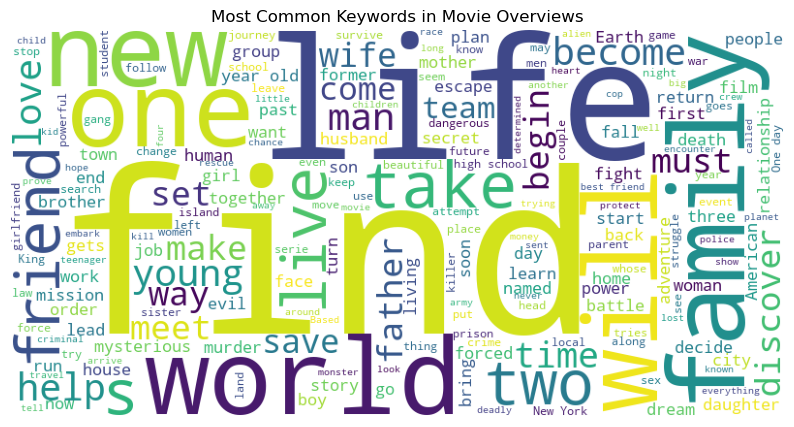

In [41]:
# Visualize the Most Common Keywords using a WordCloud

wc_plot = wordcloud.WordCloud(width=800, height=400,
                              background_color='white').generate(' '.join(movies['overview']))

plt.figure(figsize=(10, 6))
plt.imshow(wc_plot)
plt.axis('off')
plt.title('Most Common Keywords in Movie Overviews')
plt.show()

In [42]:
# Text length analysis
# Calculate the length of each overview in terms of characters, words, and sentences
# I prefer to create a new DataFrame for this analysis

movies_overview = pd.DataFrame(movies[['title', 'overview', 'popularity']])

overviews = movies['overview']

overview_lengths_characters = [len(overview) for overview in overviews]
overview_lengths_words = [len(overview.split()) for overview in overviews]
overview_lengths_sentences = [overview.count('.') + overview.count('!') + overview.count('?')
                              for overview in overviews]

movies_overview['overview_length_characters'] = overview_lengths_characters
movies_overview['overview_length_words'] = overview_lengths_words
movies_overview['overview_length_sentences'] = overview_lengths_sentences

movies_overview.head(2)

,title,overview,popularity,overview_length_characters,overview_length_words,overview_length_sentences
0,Spider-Man: Across the Spider-Verse,"After reuniting with Gwen Stacy, Brooklyn’s fu...",2904.593,412,65,2
1,Elemental,"In a city where fire, water, land and air resi...",2396.197,178,30,1


Test: Are the length of the characters of the overviews and the popularity correlated?

In [43]:
correlation = movies_overview['overview_length_characters'].corr(movies_overview['popularity'])
print(f"Correlation between text length and popularity: {correlation:.2f}")

Correlation between text length and popularity: -0.00


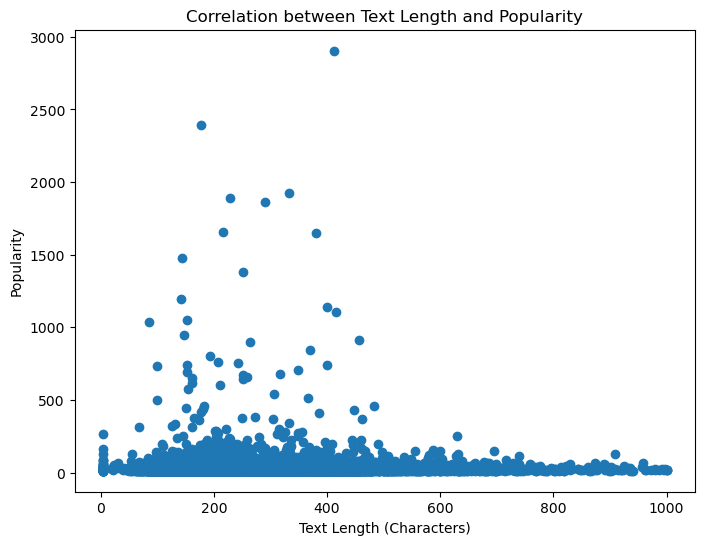

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(movies_overview['overview_length_characters'], movies_overview['popularity'])
plt.title('Correlation between Text Length and Popularity')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Popularity')
plt.show()

Result: The test indicates that there is no linear relationship between these two variables. There is no pattern or trend that can be observed.

/tmp/ipykernel_32/2787721810.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  movies['genre_ids_clean'] = movies['genre_ids'].str.replace(r'[\[\] ]', '')


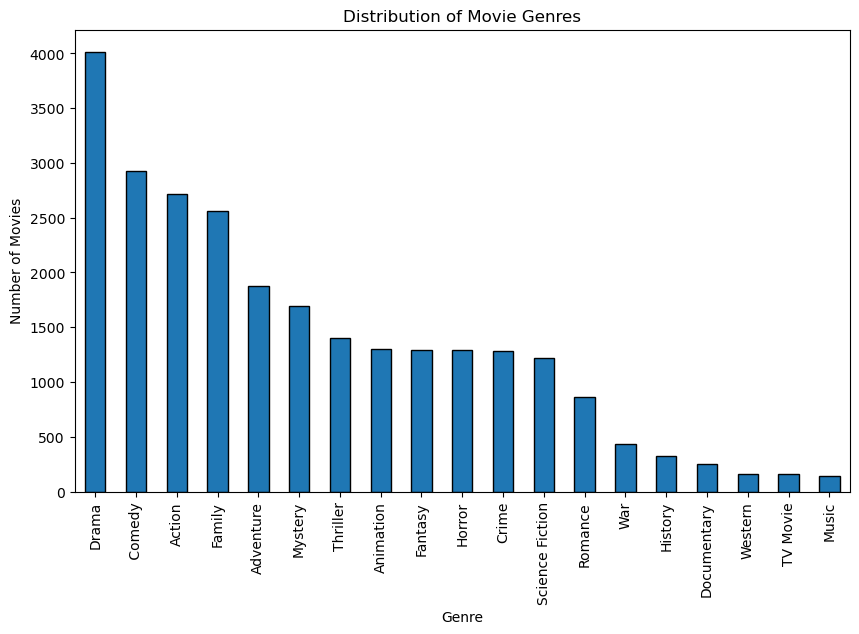

In [45]:
# Visualize the distribution of movie genres

movies['genre_ids_clean'] = movies['genre_ids'].str.replace(r'[\[\] ]', '')

all_genres = [genre for genres in movies['genre_ids_clean'].str.split(',') for genre in genres]

genre_counts = Counter(all_genres)

genre_counts_series = pd.Series(genre_counts)
genre_counts_series.drop('', inplace = True)

genre_counts_series.index = ['Animation', 'Action' , 'Adventure', 'Science Fiction',' Comedy',
'Fantasy', 'Horror','Mystery','Thriller', 'Family', 'Romance', 'Crime', 
'Drama', 'War', 'History', 'TV Movie', 'Documentary', 'Music', 'Western']

sorted_genre_counts = genre_counts_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_genre_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Genres')
plt.show()

In [46]:
movies = movies.drop(columns = 'genre_ids_clean')

# Content Genre-Based Filtering

Test: Let's see if films can be recommended based on the genres of another film.

In [80]:
def film_recommender(film_name, dataframe, num_recommendations):
    matching_films = dataframe[dataframe["title"].str.lower() == film_name.lower()]

    if matching_films.empty:
        return f"No film with the name '{film_name}' found in the dataset."

    genre = matching_films["genre_ids"].iloc[0]
    genre_list = genre.split(",")
    recommended_films = []

    for index, row in dataframe.iterrows():
        film_genres = row["genre_ids"].split(",")
        common_genres = set(genre_list) & set(film_genres)

        if len(common_genres) > 0 and row["title"].lower() != film_name.lower():
            row["num_common_genres"] = len(common_genres)
            recommended_films.append(row)
            
    sorted_films = sorted(
        recommended_films,
        key=lambda x: (x["num_common_genres"], x["vote_average"]),
        reverse=True,
    )

    recommended_titles = [film["title"] for film in sorted_films[:num_recommendations]]

    return recommended_titles

user_film = input("Enter the name of a film: ")
recommendations = film_recommender(user_film, movies, num_recommendations=6)
print("Recommended Films:")
for film in recommendations:
    print(film)

Enter the name of a film:  oppenheimer


Recommended Films:
Jesus
Joseph
Hidden Figures
The Elephant Man
Ayla: The Daughter of War
Andrei Rublev


Result: Recommending based on genres is possible and is also my personal favourite of all the simple movie recommenders.

# Loading and Understanding the Ratings Data

In [48]:
ratings = pd.read_csv('/kaggle/input/movie-lens-25m-dataset/ml-25m/ratings.csv')

In [49]:
ratings.shape

(25000095, 4)

In [50]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [51]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [52]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [53]:
ratings.duplicated().sum()

0

In [54]:
movie_lens = pd.read_csv('/kaggle/input/movie-lens-25m-dataset/ml-25m/movies.csv')

In [55]:
movie_lens.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [56]:
movie_lens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [57]:
movie_lens[movie_lens.duplicated(subset=['title'])]

,movieId,title,genres
9065,26982,Men with Guns (1997),Drama
12909,64997,War of the Worlds (2005),Action|Sci-Fi
12984,65665,Hamlet (2000),Drama
13177,67459,Chaos (2005),Crime|Drama|Horror
16120,85070,Blackout (2007),Drama
...,...,...,...
61521,206117,The Lonely Island Presents: The Unauthorized B...,Comedy
61525,206125,Lost & Found (2018),Comedy|Drama
61697,206674,Camino (2016),Comedy
61800,206925,The Plague (2006),Documentary


In [58]:
movie_lens = movie_lens.drop_duplicates(subset=['title'])

Test: Let's see if the TMDB dataset can be merged with the ratings dataset using the titles of the movie_lens dataset and if there will be any matches

In [59]:
print(movies.shape)
movies.head(2)

(10000, 10)


,id,title,genre_ids,popularity,release_date,original_language,vote_average,vote_count,overview,sentiment
0,569094,Spider-Man: Across the Spider-Verse,"[16, 28, 12, 878]",2904.593,2023-05-31,en,8.5,3420,"After reuniting with Gwen Stacy, Brooklyn’s fu...",Positive
1,976573,Elemental,"[16, 35, 10751, 14, 10749]",2396.197,2023-06-14,en,7.7,943,"In a city where fire, water, land and air resi...",Negative


In [60]:
print(movie_lens.shape)
movie_lens.head(2)

(62325, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [61]:
print(ratings.shape)
ratings.head(2)

(25000095, 4)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817


# Data prerpocessing

In [62]:
# Use regular expressions to remove years and leading/trailing spaces from the titles 

def remove_year(title):
    cleaned_title = re.sub(r'\s?\(\d{4}\)', '', title)
    return cleaned_title.strip()

movie_lens['title'] = movie_lens['title'].apply(remove_year)

In [63]:
movie_datasets_merged = movie_lens.merge(movies, on='title')

In [64]:
movie_datasets_merged.duplicated(subset=['title']).sum()

2025

In [65]:
movie_datasets_merged = movie_datasets_merged.drop_duplicates(subset=['title'])

In [66]:
print(movie_datasets_merged.shape)
movie_datasets_merged.head(2)

(5177, 12)


,movieId,title,genres,id,genre_ids,popularity,release_date,original_language,vote_average,vote_count,overview,sentiment
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,862,"[16, 12, 10751, 35]",116.884,1995-10-30,en,8.0,17003,"Led by Woody, Andy's toys live happily in his ...",Positive
1,2,Jumanji,Adventure|Children|Fantasy,8844,"[12, 14, 10751]",18.141,1995-12-15,en,7.2,9768,When siblings Judy and Peter discover an encha...,Negative


In [67]:
movie_datasets_merged = movie_datasets_merged.drop(columns='genres')

In [68]:
movie_datasets_merged.head(2)

,movieId,title,id,genre_ids,popularity,release_date,original_language,vote_average,vote_count,overview,sentiment
0,1,Toy Story,862,"[16, 12, 10751, 35]",116.884,1995-10-30,en,8.0,17003,"Led by Woody, Andy's toys live happily in his ...",Positive
1,2,Jumanji,8844,"[12, 14, 10751]",18.141,1995-12-15,en,7.2,9768,When siblings Judy and Peter discover an encha...,Negative


In [69]:
movie_ratings_merged = movie_datasets_merged.merge(ratings, on='movieId')

In [70]:
print(movie_datasets_merged.shape)
movie_ratings_merged.head(2)

(5177, 11)


,movieId,title,id,genre_ids,popularity,release_date,original_language,vote_average,vote_count,overview,sentiment,userId,rating,timestamp
0,1,Toy Story,862,"[16, 12, 10751, 35]",116.884,1995-10-30,en,8.0,17003,"Led by Woody, Andy's toys live happily in his ...",Positive,2,3.5,1141415820
1,1,Toy Story,862,"[16, 12, 10751, 35]",116.884,1995-10-30,en,8.0,17003,"Led by Woody, Andy's toys live happily in his ...",Positive,3,4.0,1439472215


Result: The merge was successful and the ratings data match to almost 50% of the TMDB data.

# Feature selection and sampling

In [71]:
user_based = movie_ratings_merged[['userId', 'title', 'rating']]
unique_users = user_based['userId'].unique()
users_to_keep = unique_users[:100]
sample = user_based[user_based['userId'].isin(users_to_keep)]
sample.shape

(11881, 3)

In [72]:
user_based.head()

,userId,title,rating
0,2,Toy Story,3.5
1,3,Toy Story,4.0
2,4,Toy Story,3.0
3,5,Toy Story,4.0
4,8,Toy Story,4.0


In [73]:
# Change userIds to 0-99

user_id = sample['userId'].unique()
new_ids = list(range(0, 100))
new_names = {old_ids: new_id for old_ids, new_id in zip(user_id, new_ids)}
sample.loc[:, 'userId'] = sample['userId'].replace(new_names)

/tmp/ipykernel_32/3071632744.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:, 'userId'] = sample['userId'].replace(new_names)


In [74]:
sample.head()

,userId,title,rating
0,0,Toy Story,3.5
1,1,Toy Story,4.0
2,2,Toy Story,3.0
3,3,Toy Story,4.0
4,4,Toy Story,4.0


# User-Based Collaborative Filtering

Test: Can films be recommended to users based only on their ratings? I will test this using the Surprise library.

In [82]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(sample[['userId', 'title', 'rating']], reader)

model = SVD()

trainset = data.build_full_trainset()
model.fit(trainset)


user_id = int(input("Enter your user ID: "))

if user_id < 0 or user_id > 99:
    raise ValueError("User ID must be between 0 and 99")

testset = trainset.build_anti_testset()
predictions = model.test(testset)

predictions.sort(key=lambda x: x.est, reverse=True)

recommended_items = set()
num_recommendations = 5
for pred in predictions:
    item_id = pred.iid
    if item_id not in recommended_items:
        recommended_items.add(item_id)
        num_recommendations -= 1
        if num_recommendations == 0:
            break

print("Recommended items:")
for item_id in recommended_items:
    print(f"{item_id}")

Enter your user ID:  22


Recommended items:
Trainspotting
E.T. the Extra-Terrestrial
One Flew Over the Cuckoo's Nest
Alien
Schindler's List


Result: It is not only possible but it is also perfect for catching the personal taste of a particular user.

Test: Let's see the estimated predictions for various users and films and let's use the mean absolute error (MAE) and the root mean squared error (RMSE) to evaluate the accuracy of the recommendations.

In [76]:
print(model.predict(0, "Schindler's List"))
print(model.predict(2, "Schindler's List"))
print(model.predict(88, "Pulp Fiction"))
print(model.predict(99, "Pulp Fiction"))

user: 0          item: Schindler's List r_ui = None   est = 4.79   {'was_impossible': False}
user: 2          item: Schindler's List r_ui = None   est = 4.25   {'was_impossible': False}
user: 88         item: Pulp Fiction r_ui = None   est = 3.67   {'was_impossible': False}
user: 99         item: Pulp Fiction r_ui = None   est = 3.49   {'was_impossible': False}


In [77]:
# Use Accuracy from Surprise to evaluate the model

mae = accuracy.mae(predictions)
rmse = accuracy.rmse(predictions)

MAE:  0.3464
RMSE: 0.4389


Result: As lower values of MAE and the RMSE indicate good model performance, that means the model is making relatively accurate predictions.

# Conclusion:
In this data science project, after exploring and preprocessing the movie dataset I performed EDA to gain insights of the distribution and relationship of the data. Then I delved into text analysis, sentiment analysis and feature engineering to extract meaningful information from the movie overviews. Last but not least I built various recommender systems which can be used for building more complex and advanced recommender systems.

# What's left for the future:

1. To find and add more data, like actors, directors, etc.
2. To try to combine all the methods in one ultimate recommender system.
3. To use deep learning to improve the model or to create a new better one.

#  Some of the references that I learned from:

1. https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/

2. https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75